# Clasificación básica: clasificar imágenes de ropa

Esta guía entrena un modelo de red neuronal para clasificar imágenes de ropa, como tennis y camisetas. 

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.10.0


## Importando el dataset Fashion MNIST

Se va a utilizar el Fashion MNIST dataset, que contiene 70,000 imágenes en escala de grises con 10 categorías. Las imágenes muestran artículos de ropa individuales a una baja resolución (28x28)

<img src='https://tensorflow.org/images/fashion-mnist-sprite.png' width='700'>

En esta ocasión se utilizarán 60,000 imágenes para entrenar la red y 10,000 para evaluar con qué tanta precisión la red aprende a clasificar las imágenes. Afortunadamente se puede utilizar el conjunto de datos directo de `TensorFlow`.

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


Al cargar el dataset obtenemos cuatro arrays de NumPy:

- `train_images` y `train_labels` constituyen el conjunto de *entrenamiento*, es decir los datos que el modelo utiliza para aprender.
- El modelo se pone a prueba con el conjunto de *validación*, que son `test_images` y `test_labels`.

Las imágenes son arrays de NumPy de tamaño 28x28, con valores de pixeles entre 0 y 255. Los `labels` son un array de enteros, que van de 0 a 9. Estos corresponden a la *clase* de ropa que la imagen representa:

|Label|Clase|
|:---:|:---:|
|0|Camiseta/Top|
|1|Pantalón|
|2|Suéter|
|3|Vestido|
|4|Abrigo|
|5|Zapatilla|
|6|Playera|
|7|Tennis|
|8|Bolsa|
|9|Bota|

Cada imagen se asigna a una sola etiqueta. Y ya que los nombres de las clases no están incluidas en el dataset, los almacenaremos por aquí para utilizarlos después, cuando grafiquemos las imágenes.

In [3]:
class_names = ['Camiseta/Top', 'Pantalón', 'Suéter', 'Vestido', 'Abrigo', 'Zapatilla', 'Playera', 'Tennis', 'Bolsa', 'Bota']

## Explorando los datos

Vamos a hacer una pequeña exploración de los datos antes de entrenar el modelo. Veamos qué forma tienen los datos de entrenamiento:

In [4]:
train_images.shape

(60000, 28, 28)

Podemos ver que contiene 60,000 elementos de tamaño 28 x 28. 
De manera similar, vemos que existen 60,000 etiquetas asociadas en el conjunto de entrenamiento:

In [ ]:
len(train_labels)

60000

Cada etiqueta es un número entero entre 0 y 9:

In [6]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

De manera similar, existen 10,000 imágenes en el conjunto de validación, de tamaño 28 x 28 pixeles y tenemos sus 10,000 etiquetas asociadas:

In [8]:
print(test_images.shape)
print(len(test_labels))

(10000, 28, 28)
10000


## Pre procesamiento de los datos

Debemos de pre procesar los datos antes de entrenar la red. Por curiosidad, veamos cómo se ve la primera imagen del conjunto de entrenamiento:

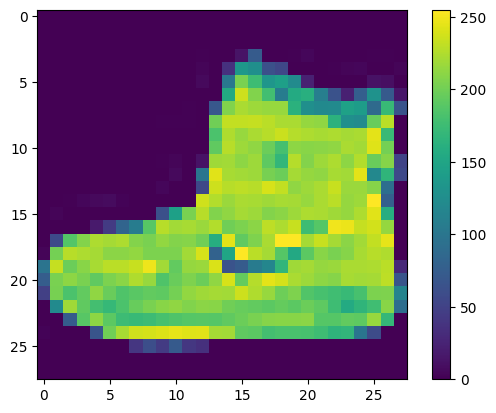

In [9]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

Entonces tenemos que escalar estos valores a un rango de 0 a 1, en vez de 0 a 255, antes de usarlos para alimentar el modelo. Para hacerlo, basta con dividir los valores entre 255. 

**Nota: Es importante que tanto el conjunto de entrenamiento, como el de validación sean pre procesados de la misma forma.**

In [10]:
train_images = train_images / 255.

test_images = test_images / 255. 

Para verificar que quedó en el formato correcto y que estamos listos para empezar a entrenar, veamos las primeras 25 imágenes del conjunto de entrenamiento y pongamos la etiqueta correspondiente.

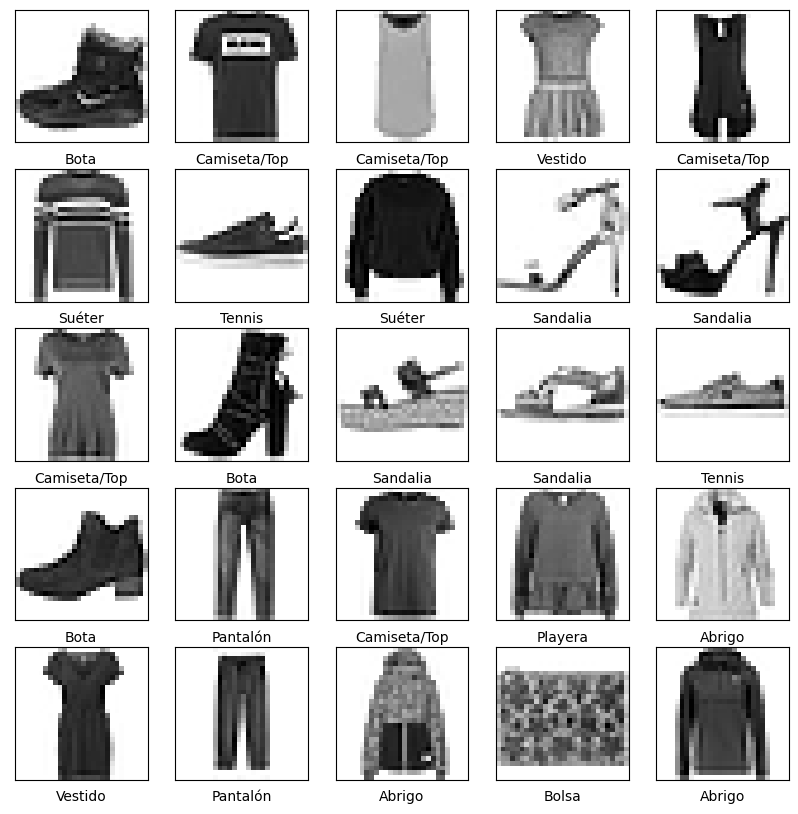

In [11]:
plt.figure(figsize=(10,10))

for i in range(25):

    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap = plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])

plt.show()

## Construyendo el modelo

Para construir el modelo de la red neuronal, debemos configurar las capas del modelo, y después compilarlo.

### Configurando las capas

El bloque de construcción básico de una red neuronal es la *capa* (*layer*). Las capas extraen representaciones de los datos con los que son alimentados. Esperamos que esas representaciones sean significativas para el problema a resolver.

La mayoría de los modelos de deep learning consisten en cadenas de capas simples. Muchas de estas capas, como la `tf.keras.layers.Dense`, tienen parámetros que son aprendidos durante el entrenamiento.

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (28,28)),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(10)
])

La primera capa en esta red, `tf.keras.layers.Flatten`, transforma el formato de las imágenes de un array 2-dimensional (de 28 x 28 pixeles), a un array 1-dimensional (de 28*28 = 784 pixeles). Podemos pensar que lo que hace esta capa es apilar los renglones de pixeles horizontalmente uno tras otro. Esta capa en particular no posee parámetros para aprender; sólo cambia el formato de los datos.

Después de que los pixeles son aplanados, la red consiste de una secuencia de dos capas `tf.keras.layers.Dense`. Estas capas son capas neuronales densamente conectadas, o *completamente conectadas*¨. La primera capa `Dense` tiene 128 neuronas. La segunda contiene un array de logits con longitud igual a 19. Cada nodo contiene un score que indica que la imagen pertenece a una de las 10 posibles clases.

## Compilando el modelo

Antes de que el modelo esté listo para entrenar, se necesitan un par de configuraciones extra. Estas se añaden durante el paso de *compilación* del modelo:

- Función de costo (Loss function): Este parámetro mide qué tan preciso es el modelo durante el entrenamiento. Lo que se desea es minimizar esta función para "encaminar" al modelo en la dirección correcta.

- Optimizador (Optimizer): Con este parámetro se controla cómo se actualiza el modelo basado en los datos que ve y en la función de costo.

- Métricas (Metrics): Se utiliza para monitorear el entrenamiento y los pasos de validación. Este ejemplo utiliza `accuracy` (precisión), es decir, la fracción de imágenes que son clasificadas correctamente.

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Entrenando el modelo

Entrenar la red neuronal requiere de los siguientes pasos:

1. Alimentar al modelo con los datos de entrenamiento. En este ejemplo, los datos de entrenamiento están en los arrays `train_images` y en `train_labels`.

2. El modelo va a aprender a asociar imágenes con sus etiquetas.

3. Le vamos a pedir al modelo que realice predicciones sobre un conjunto de validación, en este ejemplo, el array `test_images`.

4. Verificaremos que las predicciones correspondan a las etiquetas correctas.

Para comenzar el entrenamiento, utilizamos el método `Model.fit`:

In [15]:
history = model.fit(train_images, train_labels, epochs = 20, verbose = 1)

Epoch 1/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2108 - accuracy: 0.9215
Epoch 2/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2043 - accuracy: 0.9241
Epoch 3/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1985 - accuracy: 0.9274
Epoch 4/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1938 - accuracy: 0.9276
Epoch 5/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1883 - accuracy: 0.9296
Epoch 6/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1827 - accuracy: 0.9304
Epoch 7/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1781 - accuracy: 0.9334
Epoch 8/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1748 - accuracy: 0.9344
Epoch 9/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1709 - accuracy: 0.9358
Epoch 10/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.167

Conforme el modelo entrena, se muestran los valores de `loss` y `accuracy`. Este modelo alcanza una precisión de alrededor de 0.95 (o 95%) sobre los datos de entrenamiento.

### Evaluando la precisión

Ahora, vamos a ver cómo se comporta el modelo sobre los datos del conjunto de validación:

In [16]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose = 2)

print('\nTest accuracy:', test_acc)

313/313 - 0s - loss: 0.4130 - accuracy: 0.8889 - 406ms/epoch - 1ms/step

Test accuracy: 0.8888999819755554


Notemos que la precisión sobr el conjunto de validación es un poco menor que la precisión sobre el conjunto de entrenamiento. Esta diferencia entre precisiones es lo que se conoce como *sobreajuste* (*overfitting*). El sobreajuste se presenta cuando un modelo de machine learning tiene un desempeño peor sobre entradas nuevas y nunca antes vistas que sobre las entradas del entrenamiento.
Un modelo sobreajustado "memoriza" el ruido y los detalles del conjunto de entrenamiento, hasta el punto en el que afecta de manera negativa el desempeño del modelo sobre los nuevos datos.

### Haciendo predicciones

Sin embargo, podemos intentar hacer predicciones sobre algunas imágenes. La idea es juntar una capa softmax para convertir las salidas lineales del modelo (logits) a probabilidades, que son más fáciles de interpretar.

In [17]:
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])

In [18]:
predictions = probability_model.predict(test_images)

313/313 [==============================] - 0s 919us/step


Hasta este punto, el modelo ha hecho predicciones para la etiqueta de cada imagen en el conjunto de validación. Veamos el primer elemento.

In [19]:
predictions[0]

array([3.3453789e-16, 3.1541683e-20, 7.8071814e-19, 2.4521278e-25,
       5.6368027e-22, 3.3036947e-08, 2.5171708e-19, 8.0095488e-05,
       8.9242148e-19, 9.9991989e-01], dtype=float32)

En este contexto, una predicción consiste en un array de 10 números. Cada uno representa la "certeza" del modelo de que la imagen corresponde a una de las 10 clases de ropa. Podemos identificar qué etiqueta tiene el valor de confianza más alto:

In [20]:
np.argmax(predictions[0])

9

In [22]:
class_names[np.argmax(predictions[0])]

'Bota'

Por lo tanto, el modelo tiene mayor certeza de predecir que la imagen representa una bota. Veamos el valor correcto, el cual se encuentra en `test_labels`.

In [23]:
test_labels[0]

9

Veamos cómo se ve el conjunto completo de las predicciones.

In [25]:
def plot_image(i, predictions_array, true_label, img):

    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap = plt.cm.binary)

    predicted_label = np.argmax(predictions_array)

    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel('{} {:2.0f}% ({})'.format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]),
                                         color = color)
    
def plot_value_array(i, predictions_array, true_label):

        true_label = true_label[i]
        plt.grid(False)
        plt.xticks(range(10))
        plt.yticks([])
        thisplot = plt.bar(range(10), predictions_array, color = '#777777')
        plt.ylim([0,1])
        predicted_label = np.argmax(predictions_array)

        thisplot[predicted_label].set_color('red')
        thisplot[true_label].set_color('blue')

### Verificando las predicciones.

Veamos la primera imagen, su predicción y el array de predicciones. Las etiquetas predichas correctas están en color azul, mientras que las etiquetas incorrectas están en rojo.

El número nos da el porcentaje de confianza para la etiqueda predicha.

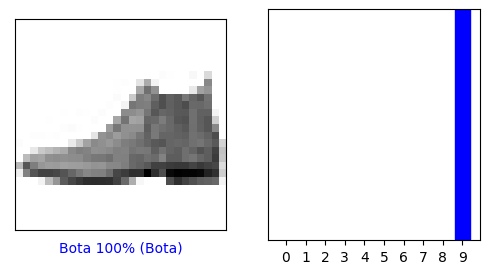

In [26]:
i = 0

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i], test_labels)
plt.show()

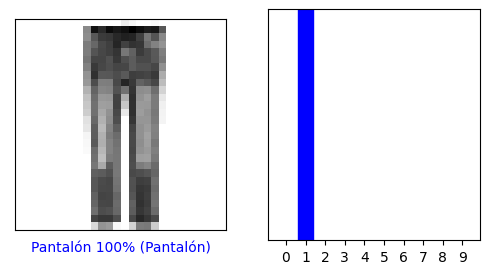

In [27]:
i = 15

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i], test_labels)
plt.show()

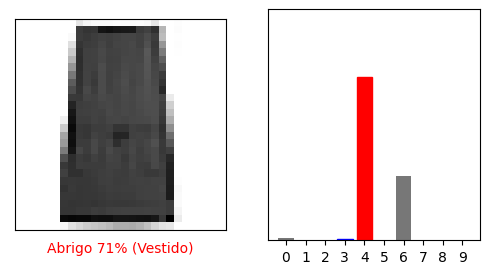

In [29]:
i = 42

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i], test_labels)
plt.show()

Ahora, grafiquemos varias imágenes con sus respectivas predicciones. Es importante observar que el modelo puede estar equivocado a pesar de tener niveles de confianza altos.

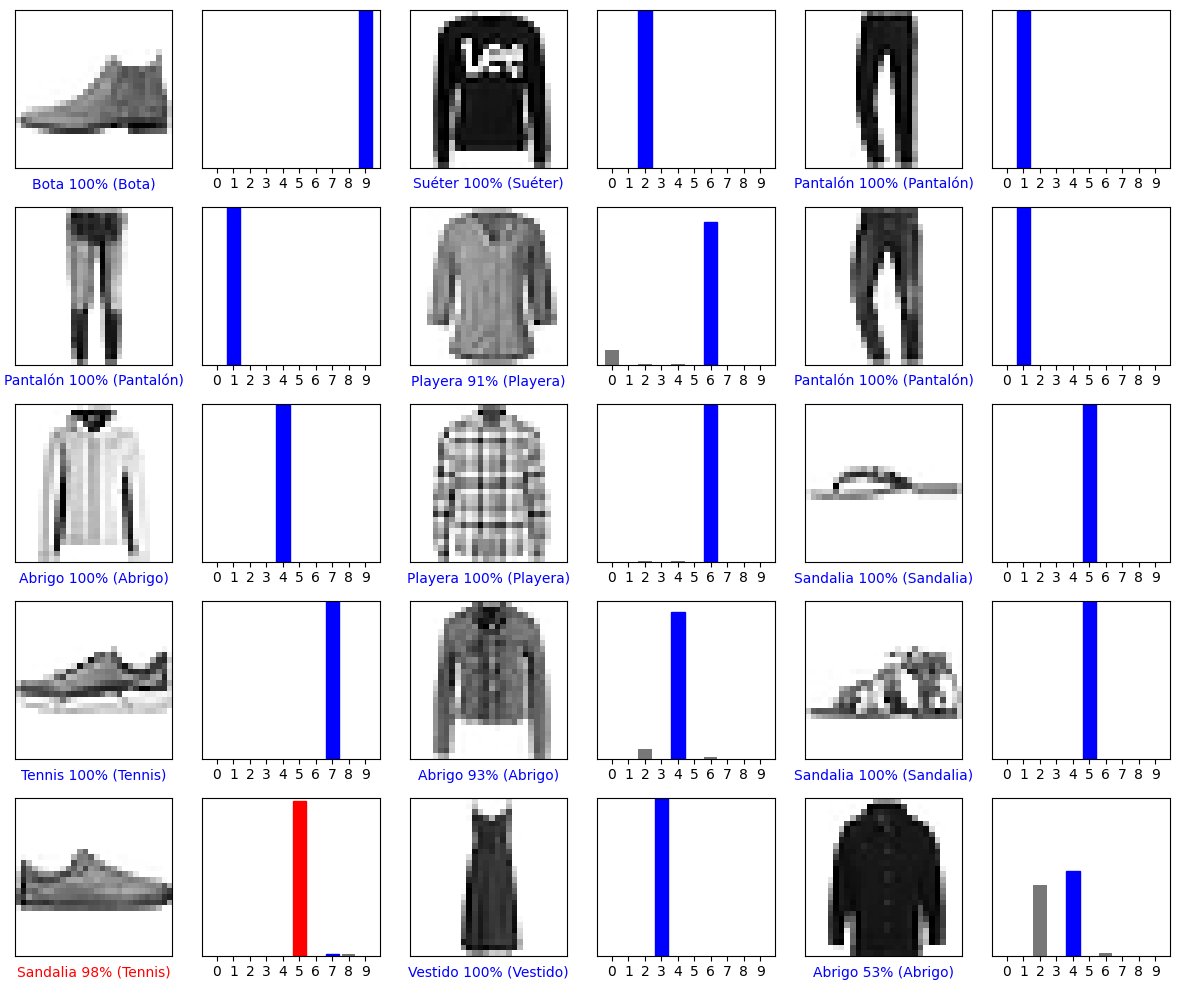

In [31]:
rows = 5
cols = 3
num_images = rows*cols

plt.figure(figsize=(2*2*cols, 2*rows))

for i in range(num_images):
    plt.subplot(rows, 2*cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(rows, 2*cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)

plt.tight_layout()
plt.show()

## Usando el modelo entrenado

Finalmente, podemos utilizar el modelo entrenado para hacer una predicción de una sola imagen.

In [40]:
# Tomamos una sola imagen del dataset

img = test_images[16]

print(img.shape)

(28, 28)


Los modelos de `tf.keras` están optimizados para hacer predicciones sobre un *batch*, o colección, de ejemplos cada vez. Por lo que, a pesar de que estemos usando una sola imagen, debemos añadirla a una lista:

In [41]:
# Añadimos la imagen a un batch donde sea el único elemento.

img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


Ahora predecimos la etiqueta correcta para esta imagen:

In [42]:
prediction_single = probability_model.predict(img)

print(prediction_single)

1/1 [==============================] - 0s 28ms/step
[[4.5750016e-06 1.0256867e-11 9.9977130e-01 4.4037158e-15 3.5929930e-05
  1.0108515e-13 1.8821322e-04 7.9596778e-19 2.1375433e-11 3.8651464e-11]]


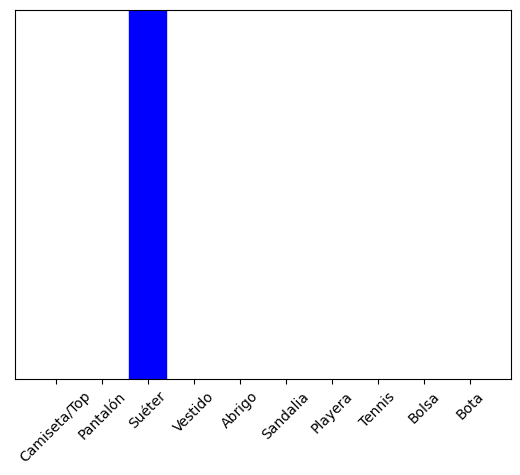

In [43]:
plot_value_array(1, prediction_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation = 45)
plt.show()